#  <center>Object Detection using Tensorflow API </center>

Convolutional Neural Networks have revolutionalized Pattern Recognition in last decades. As a result, CNNs are currently used for varous applications such as Object Detection and Image Recognition.

The TensorFlow object detection API is a software framework used for object detection tasks. Tensorflow Object Detection API and other similar APIs (Keras RCNN, YOLO) uses pre trained CNNs inside the framworks for predictions. Most of those pretrained models are trained using, the COCO dataset, the KITTI dataset, and the Open Images Dataset. These models are trained to detect some fixed type of categories of objects such as, persons, cars, dog, tooth brush and etc. If you want to detect custom objects you can retrain those models using your own datasets.

## CNN models used in Tensorflow Object Detection API

![Models used in Tensorflow Object Detection API](https://cdn-images-1.medium.com/max/800/1*-EyxSs2OiyWm-E6MSpSJiA.png)

### mAP (mean Average Precision)

AP (Average precision) is a popular metric in measuring the accuracy of object detectors like Faster R-CNN, SSD. Average precision computes the average precision value for recall value over 0 to 1

## How Object Detection is done 

1. Generates the small segments in the input image

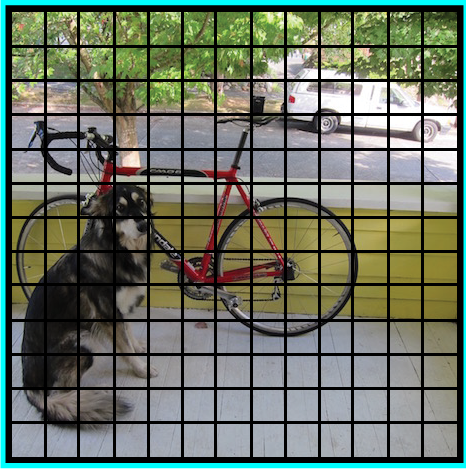

2. Feature extraction is carried out for each segmented rectangular area to predict whether the rectangle contains an valid object.
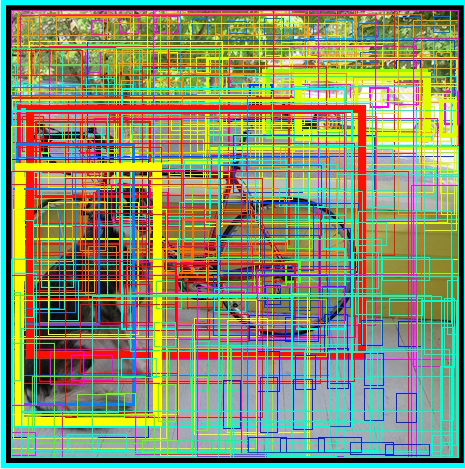

3. Overlapping boxes are combined into a single bounding rectangle (Non Maximum Supression)

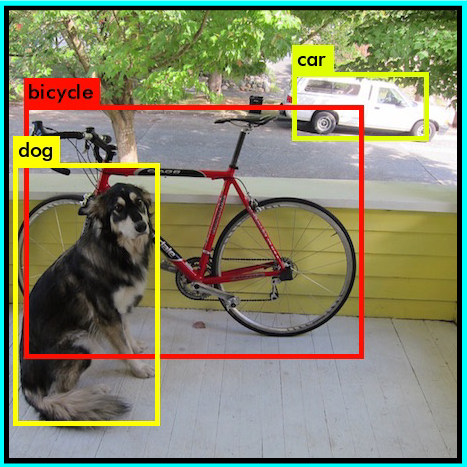

## SSD Mobile Net

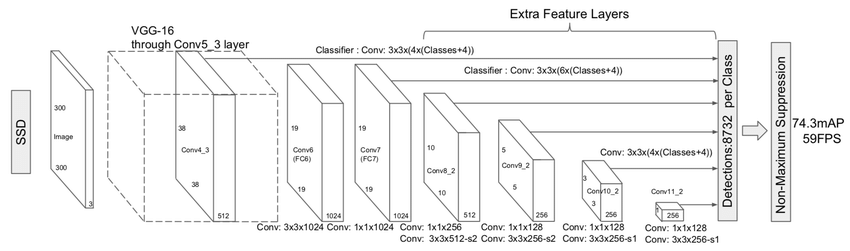

### Input

300x300 color Image (3x300x300)

### Outputs

SSD Mobile Net output the category of the detected objects and coordinates of there bounding rectangles offset (x,y,w,h)

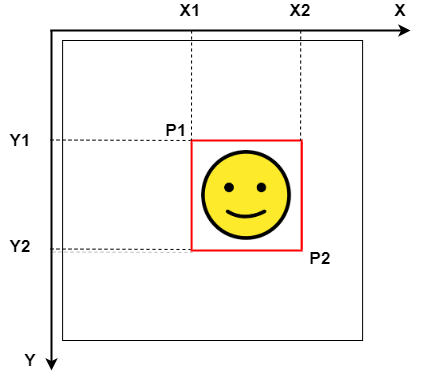

### Importing Libraries

In [128]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pathlib

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

Import the object detection module.

In [129]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

Patches:

In [130]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

#### We'll use an "SSD with Mobilenet" model here.

## Load the Model

In [131]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [141]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = r'C:\Users\hp\Desktop\Object Detection\models-master\models-master\research\object_detection\data\mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

- We will test on 3 different images:

In [142]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[WindowsPath('object_detection/test_images/img1.jpg'),
 WindowsPath('object_detection/test_images/img2.jpg'),
 WindowsPath('object_detection/test_images/img3.jpg'),
 WindowsPath('object_detection/test_images/img4.jpg')]

## Object Detection

Load an object detection model:

In [143]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Check the model's input signature, it expects a batch of 3-color images of type uint8: 

In [144]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [145]:
detection_model.output_dtypes

{'detection_scores': tf.float32,
 'num_detections': tf.float32,
 'detection_boxes': tf.float32,
 'detection_classes': tf.float32}

In [146]:
detection_model.output_shapes

{'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None]),
 'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100])}

Add a wrapper function to call the model, and cleanup the outputs:

In [147]:
def test_run_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Run it on each test image and show the results:

In [148]:
def detect_object(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = test_run_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=3,min_score_thresh=0.2)

  display(Image.fromarray(image_np))

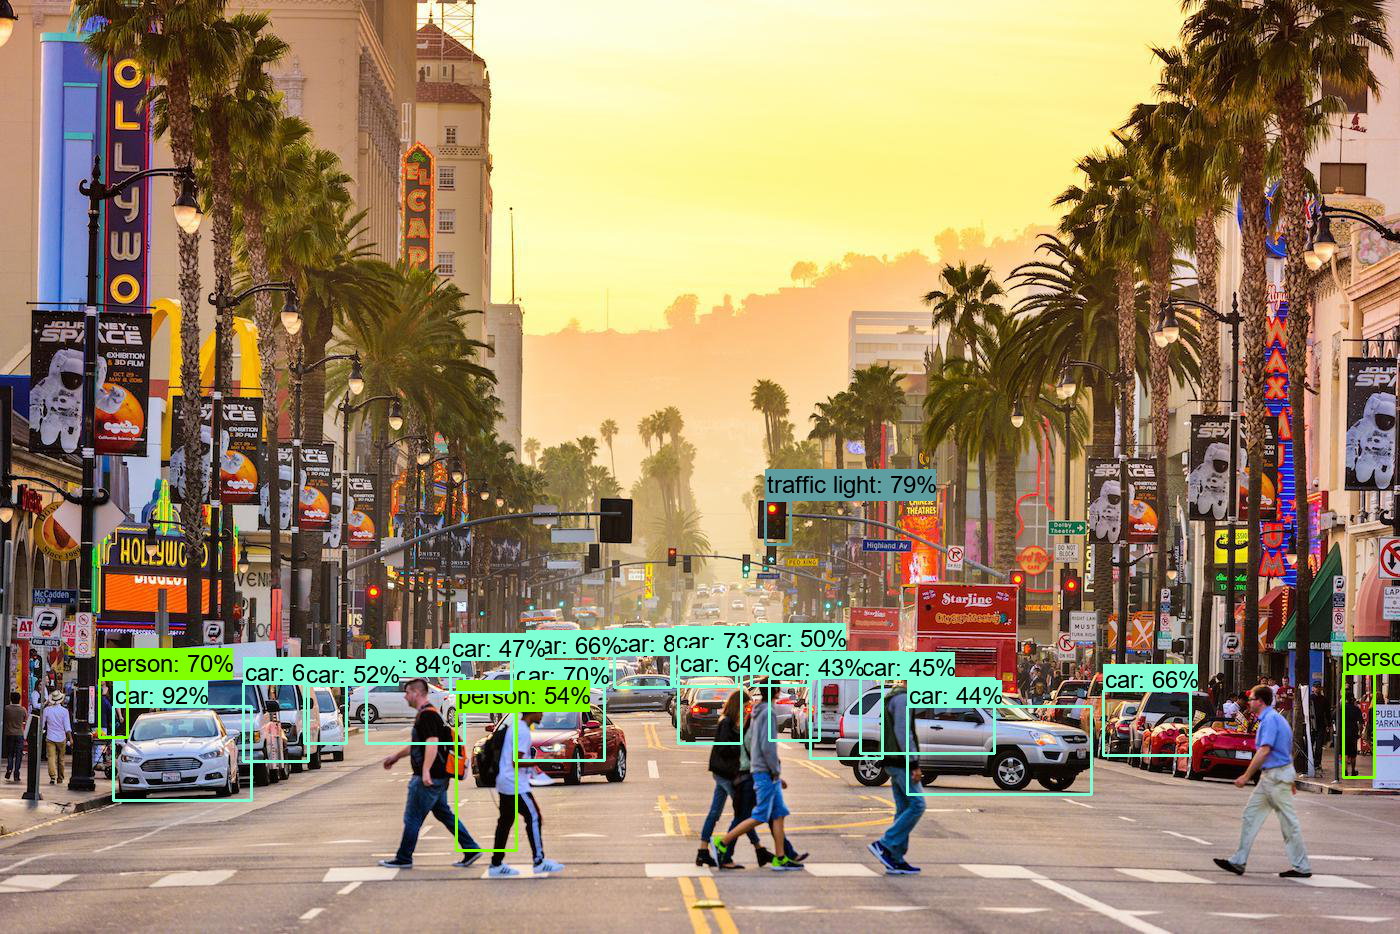

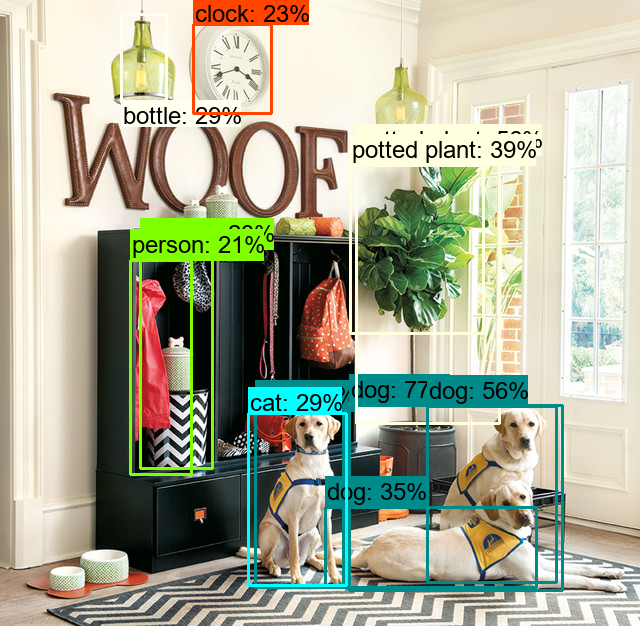

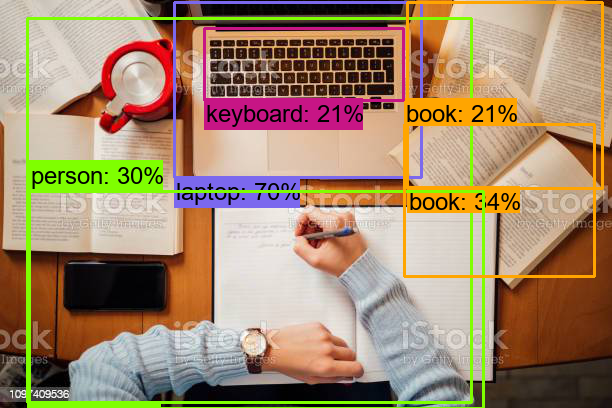

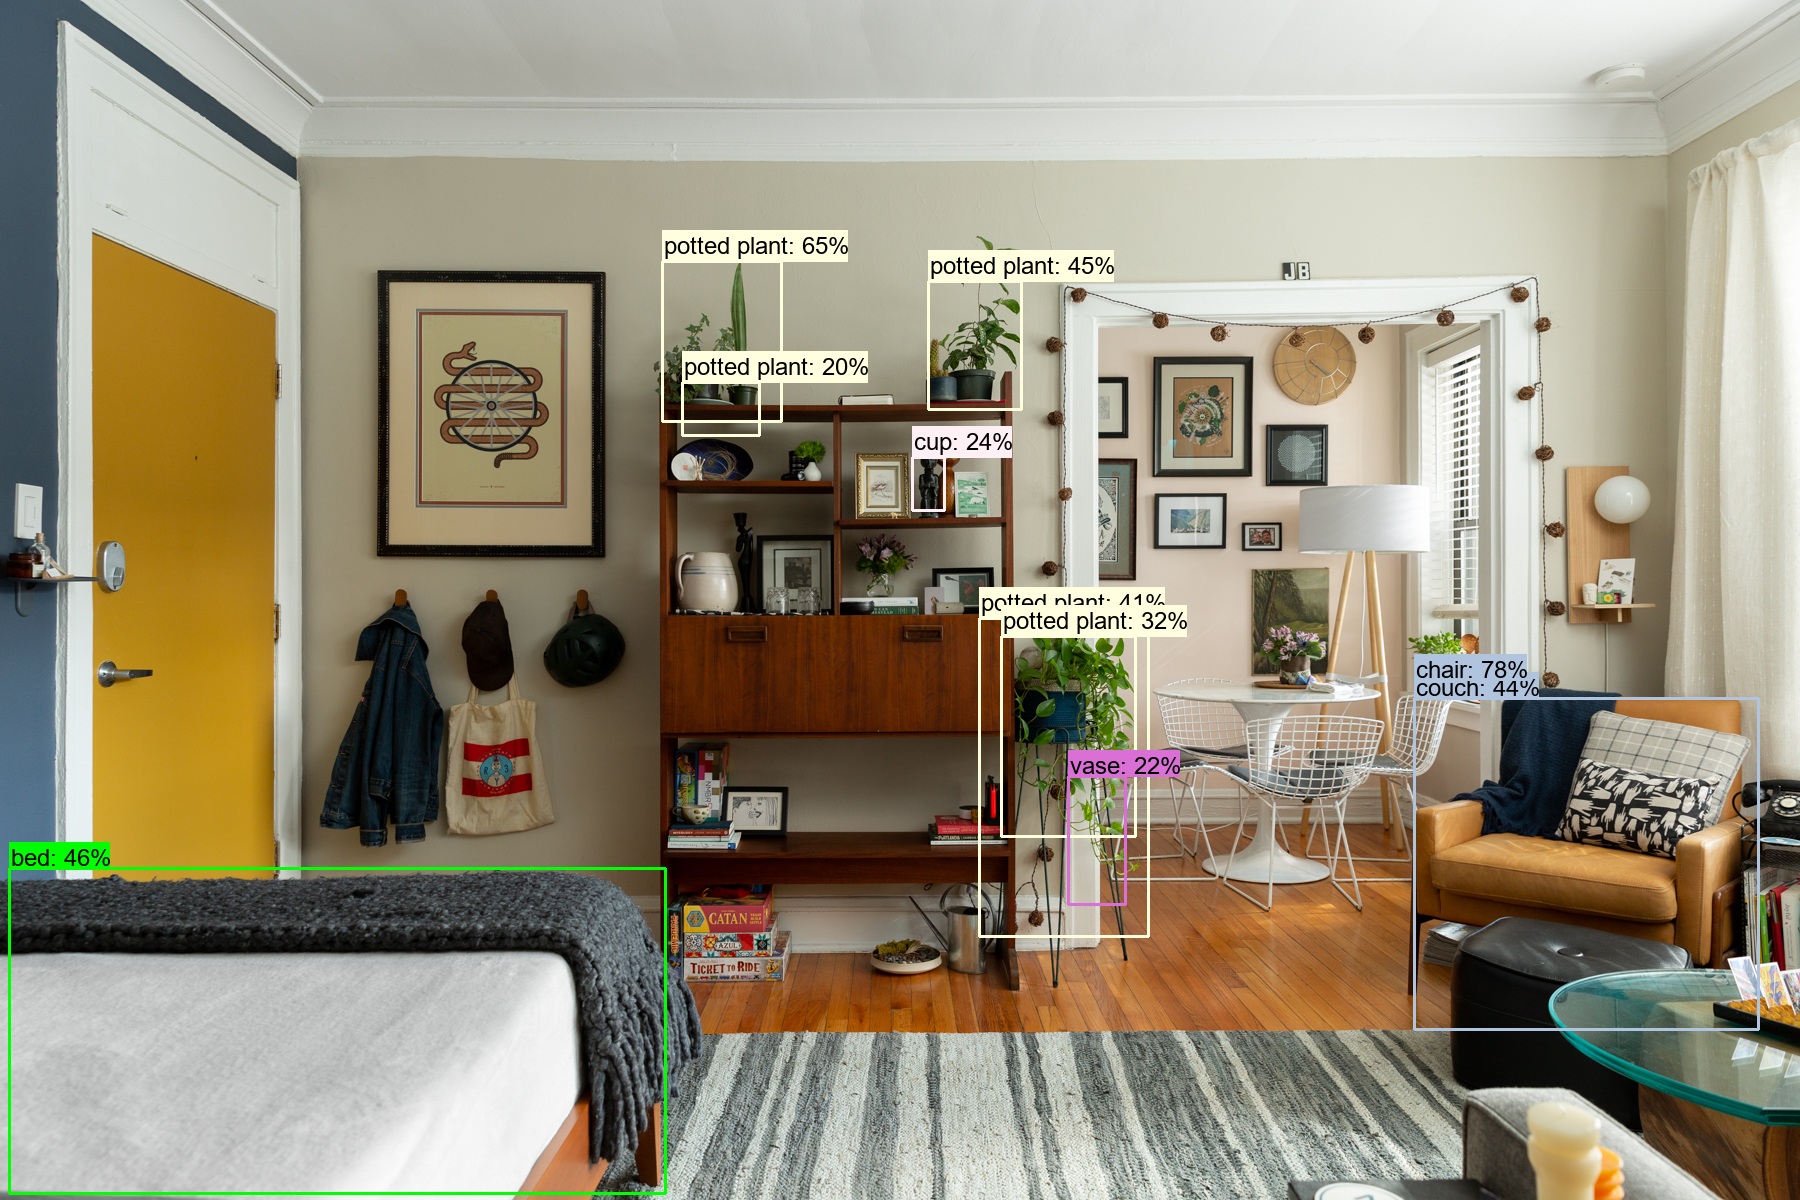

In [149]:
for image_path in TEST_IMAGE_PATHS:
  detect_object(detection_model, image_path)